# Segmentation of otoliths

In [2]:
from skimage.io import imread
from skimage.color import rgb2grey, label2rgb
from skimage.morphology import reconstruction, remove_small_objects, binary_opening
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from scipy.ndimage import gaussian_filter
import matplotlib.patches as mpatches
import numpy as np
%matplotlib inline

## Load image and turn into grayscale image 

In [3]:
image = imread('GS_AD_SH_260617_SCH_-500µm_002_gemeten.jpg')
image_greyscale = rgb2grey(image)

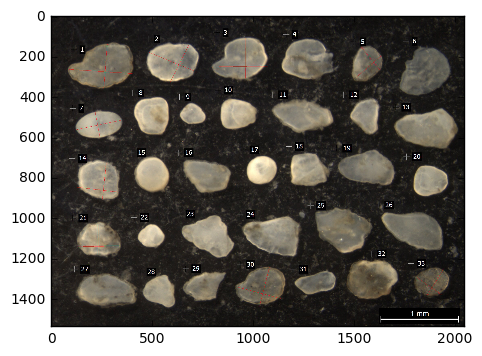

In [4]:
plt.imshow(image)

In [5]:
# smoothing
image_greyscale = gaussian_filter(image_greyscale, sigma=2)

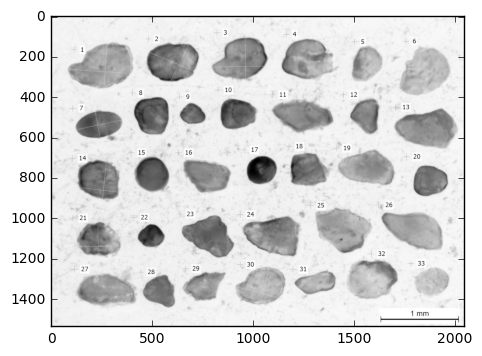

In [6]:
plt.imshow(image_greyscale, cmap='Greys')

Here, I am using mathematical morphology to only retain the otoliths.

In [7]:
seed = np.copy(image_greyscale)
seed[1:-1, 1:-1] = image_greyscale.max()
mask = image_greyscale

dilated = reconstruction(seed, mask, method='erosion')

In [8]:
segmentation = binary_opening(dilated>0.2, np.ones((30, 30)))

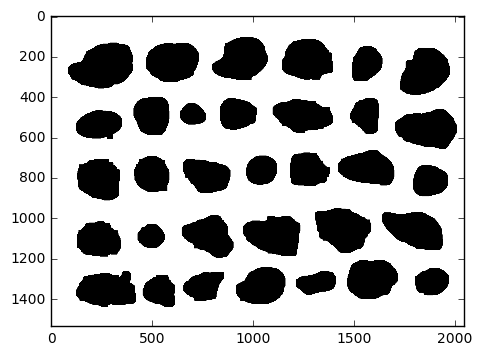

In [9]:
plt.imshow(segmentation, cmap='Greys')

In [10]:
label_image = label(segmentation)
regions = regionprops(label_image)

This is my attempt to order the regions the same way as the numbers of the images.

In [11]:
# sort on centroid
regions_sorted = []
regions.sort(key=lambda reg : reg.centroid[0], reverse=True)  # sort on rows

regions_row = [regions.pop()]
while regions:
    reg = regions.pop()  # new element for row
    min_row, min_col, max_row, max_col = regions_row[-1].bbox
    if reg.centroid[0] > min_row and reg.centroid[0] < max_row:  # part of row
        regions_row.append(reg)
    else:
        regions_sorted += sorted(regions_row, key=lambda reg : reg.centroid[1])
        regions_row = [reg]  # start new row
regions_sorted += sorted(regions_row, key=lambda reg : reg.centroid[1])
regions = regions_sorted

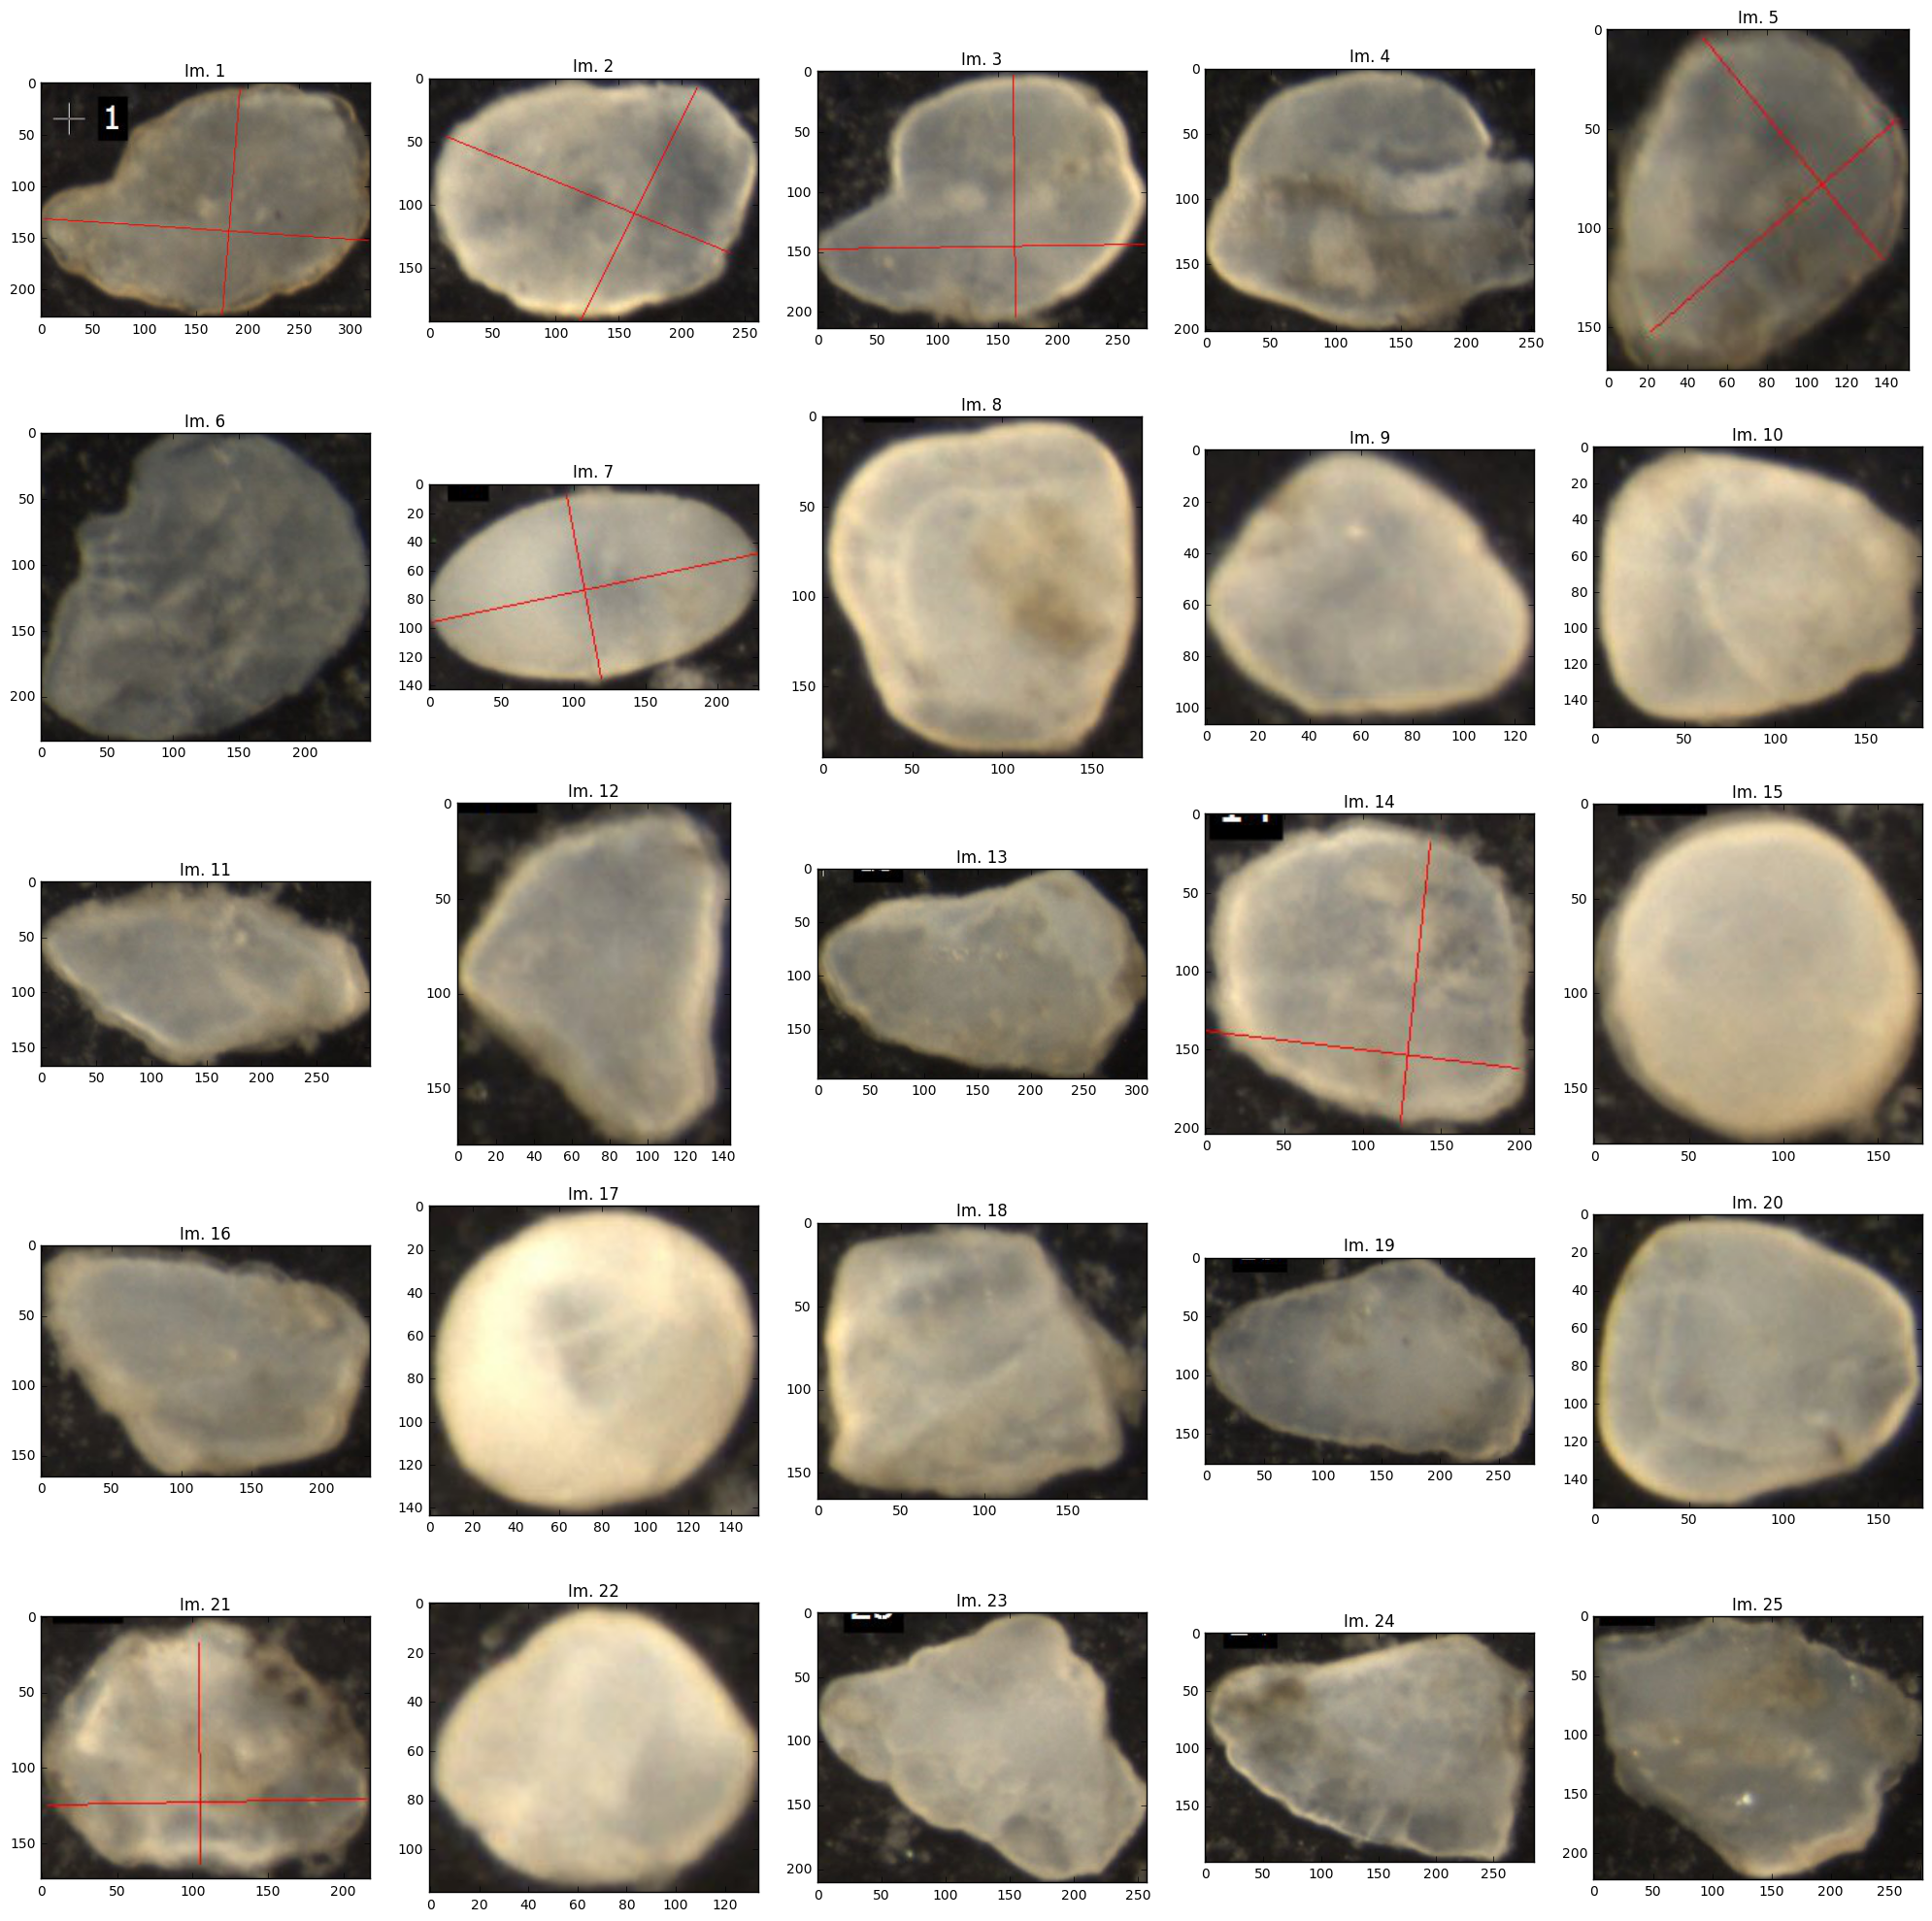

In [12]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

axes = axes.flatten()

for i in range(25):
    region = regions[i]
    ax = axes[i]
    min_row, min_col, max_row, max_col = region.bbox
    im = image[min_row:max_row][:,min_col:max_col]
    ax.imshow(im)
    ax.set_title('Im. {}'.format(i+1))
    
fig.tight_layout()

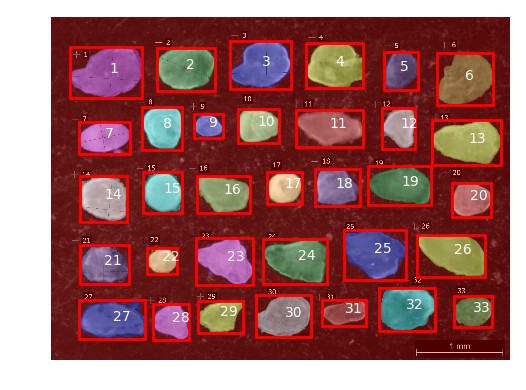

In [14]:
fig, ax = plt.subplots()
image_label_overlay = label2rgb(label_image, image=image)
ax.imshow(image_label_overlay)

for i, region in enumerate(regions):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        y, x = region.centroid
        # number of the region
        ax.text(x, y, str(i+1), color='white')

ax.set_axis_off()
fig.tight_layout()